In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [4]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [5]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [6]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

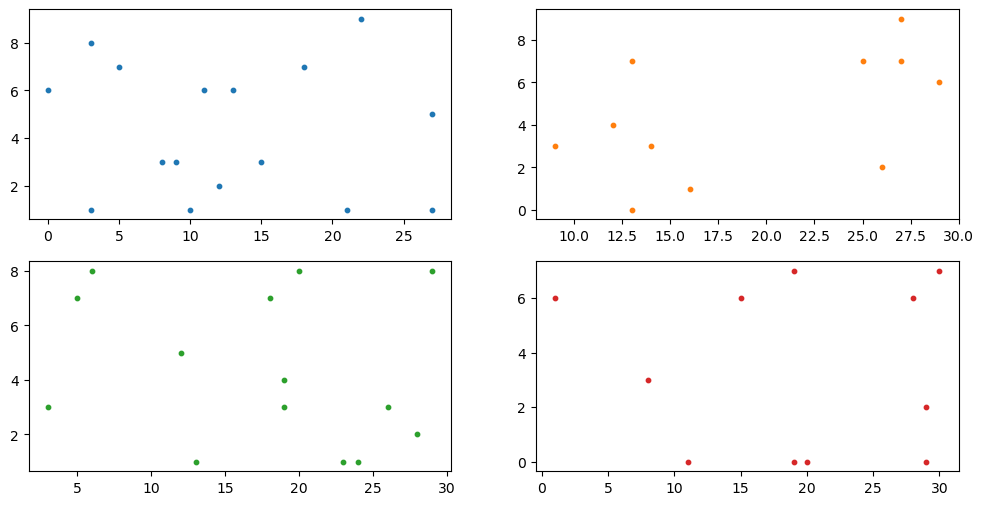

In [7]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [8]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [9]:
B_sparse[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3], dtype=int64)

In [10]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#d62728'], dtype='<U7')

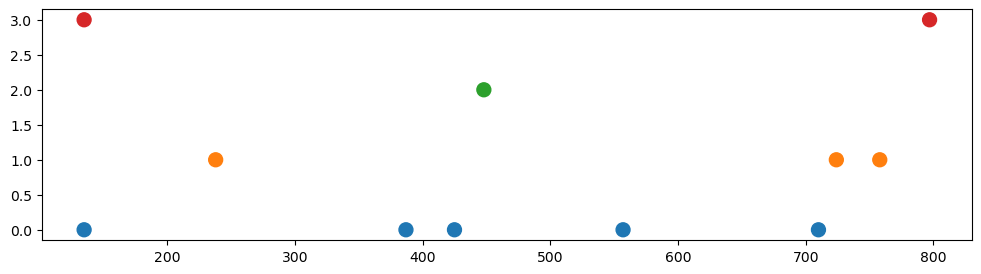

In [11]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [12]:
background_noise_fr

0

In [13]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

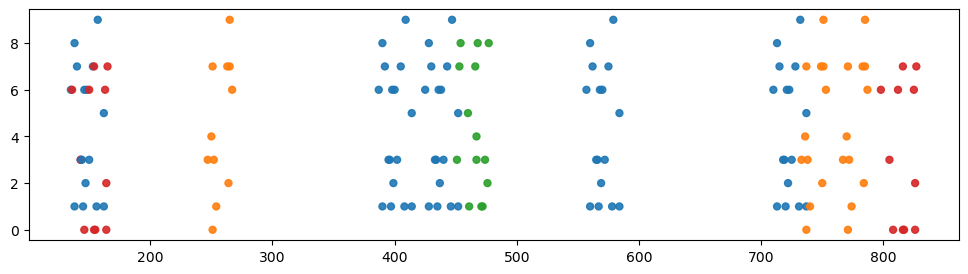

In [72]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

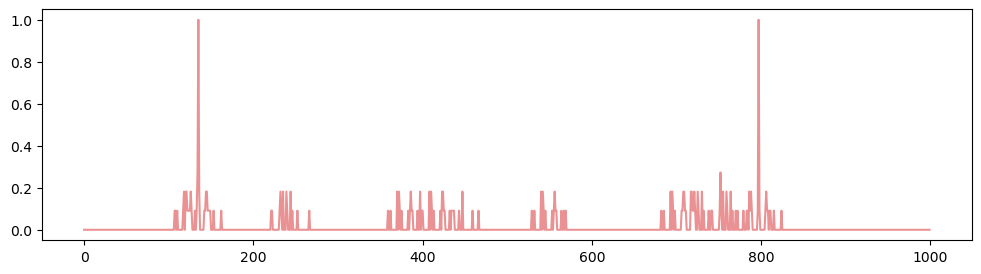

In [15]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

so... why don't I try the flawed window shift method? Even though this loses the spike information

In [16]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

 should make sure to have the labels handy...

In [17]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 149, neurons: 10, depth: 32


In [18]:
windows.shape

(149, 10, 32)

# Cross correlation of the windows??

In [19]:
B_sparse[1][B_sparse[0]==3]

array([135, 797], dtype=int64)

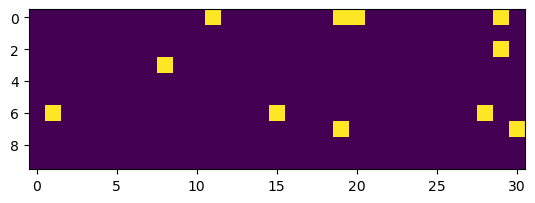

In [21]:
plt.figure()
plt.imshow(K_dense[...,3])

In [22]:
T_labels, N_labels,M_labels

(array([146, 154, 155, 164, 251, 737, 771, 808, 816, 817, 826, 138, 145,
        156, 162, 254, 390, 397, 408, 414, 428, 435, 446, 452, 461, 471,
        472, 560, 567, 578, 584, 713, 720, 731, 737, 740, 774, 147, 164,
        264, 399, 437, 476, 569, 722, 750, 784, 826, 143, 143, 144, 150,
        247, 252, 395, 396, 402, 433, 434, 440, 451, 467, 474, 565, 566,
        572, 718, 719, 725, 733, 738, 767, 772, 805, 250, 467, 736, 770,
        162, 414, 452, 460, 584, 737, 135, 136, 146, 148, 150, 163, 267,
        387, 398, 400, 425, 436, 438, 557, 568, 570, 710, 721, 723, 753,
        787, 798, 812, 825, 140, 153, 154, 165, 251, 263, 265, 392, 405,
        430, 443, 453, 466, 562, 575, 715, 728, 737, 749, 751, 771, 783,
        785, 816, 827, 138, 390, 428, 454, 468, 477, 560, 713, 157, 265,
        409, 447, 579, 732, 751, 785], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,

251


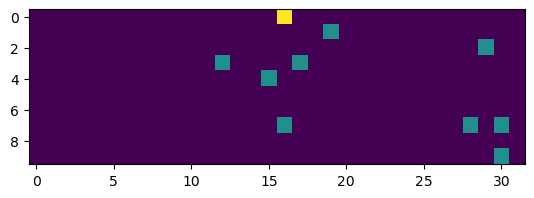

In [23]:
i = 4
print(T_labels[i])
plt.figure()
plt.imshow(windows[i])

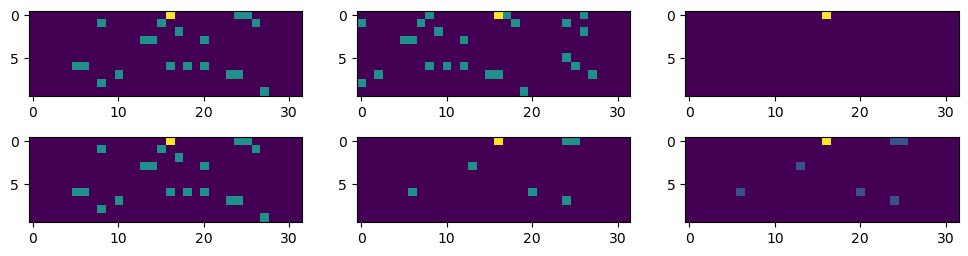

In [24]:
fig,ax = plt.subplot_mosaic('ABE;CDF',figsize=(12,3))
ax['A'].imshow(windows[0])
ax['B'].imshow(windows[1])
ax['C'].imshow(windows[0])
ax['D'].imshow(windows[7])
ax['E'].imshow(windows[0]*windows[1])
ax['F'].imshow(windows[0]*windows[7])

In [25]:
windows.shape,N_labels.shape

((149, 10, 32), (149,))

In [26]:
N_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [73]:
test = windows[N_labels==2]
test.shape

(11, 10, 32)

In [74]:
result = np.zeros((test.shape[0],test.shape[0],10,32))

In [81]:
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        result[i,j,...] = test[i]*test[j]


In [82]:
x = np.sum(result,axis=(2,3))

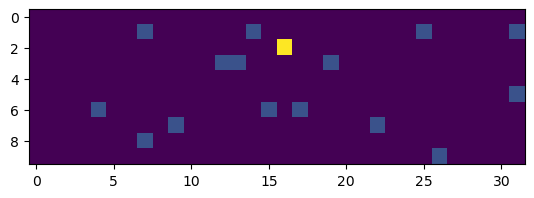

In [83]:
plt.figure()
plt.imshow(result[7,0])

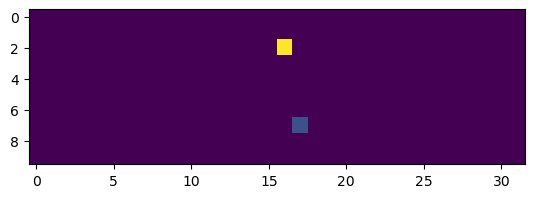

In [84]:
plt.figure()
plt.imshow(result[8,1])

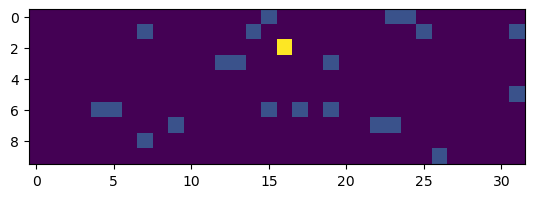

In [90]:
plt.figure()
plt.imshow(result[0,0])

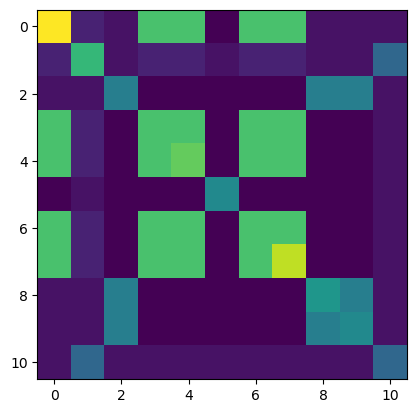

In [86]:
plt.figure()
plt.imshow(x)

For each spike, I can guess if there is a pattern repeating around it based off of the dot product between the two windows of that point... So in the above matrix I see that 5 spikes correlate highly with 4 OTHER spikes, 2 spikes correlate with just 1 OTHER spike, and 3 spikes correlate with 2 OTHER spikes. so... How can I take this data and do some clustering with it? hmmmmm...

